## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
import json
from datetime import datetime
from keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import Callback
import time
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

2025-04-06 18:21:53.739207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743963713.764873   65595 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743963713.777296   65595 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Enable GPU

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         print("Using GPU:", gpus[0])
#     except RuntimeError as e:
#         print(e)

## Load the Dataset

In [3]:
# Define image paths
clean_path = os.path.expanduser("~/filesystem1/my_dataset/celeba_64x64_25000/clean")
noisy_path = os.path.expanduser("~/filesystem1/my_dataset/celeba_64x64_25000/noisy")

# Load all image filenames
image_filenames = sorted(os.listdir(clean_path))

# Load images
clean_images = []
noisy_images = []

for fname in image_filenames:
    clean_img = Image.open(os.path.join(clean_path, fname)).convert('RGB')
    noisy_img = Image.open(os.path.join(noisy_path, fname)).convert('RGB')
    
    clean_images.append(np.array(clean_img))
    noisy_images.append(np.array(noisy_img))

# Convert lists to numpy arrays
clean_images = np.array(clean_images)
noisy_images = np.array(noisy_images)

# Split into training and testing sets
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy = train_test_split(
    clean_images, noisy_images, test_size=0.1, random_state=42)

# Normalize pixel values to [0, 1]
x_train_clean = x_train_clean.astype('float32') / 255.
x_test_clean = x_test_clean.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

# Shuffle data while maintaining alignment
perm = np.random.permutation(len(x_train_clean))
x_train_clean = x_train_clean[perm]
x_train_noisy = x_train_noisy[perm]

perm_test = np.random.permutation(len(x_test_clean))
x_test_clean = x_test_clean[perm_test]
x_test_noisy = x_test_noisy[perm_test]


In [4]:
def show_samples(clean, noisy, label1="Clean", label2="Noisy", num_samples=5):
    plt.figure(figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        # Noisy
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(noisy[i])
        plt.title(label2)
        plt.axis('off')
        
        # Clean
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(clean[i])
        plt.title(label1)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_samples_fourier(clean, noisy, label1="Clean", label2="Noisy", num_samples=5):
    plt.figure(figsize=(num_samples * 2, 4))
    
    for i in range(num_samples):
        # Handle noisy
        plt.subplot(2, num_samples, i + 1)
        f_noisy = noisy[i]
        if isinstance(f_noisy, list):  # color image (list of 3 fshifts)
            mags = [20 * np.log(np.abs(ch) + 1) for ch in f_noisy]
            combined = np.mean(mags, axis=0)  # average magnitude over RGB
        else:  # grayscale
            combined = 20 * np.log(np.abs(f_noisy) + 1)
        plt.imshow(combined, cmap='gray')
        plt.title(label2)
        plt.axis('off')
        
        # Handle clean
        plt.subplot(2, num_samples, i + 1 + num_samples)
        f_clean = clean[i]
        if isinstance(f_clean, list):  # color
            mags = [20 * np.log(np.abs(ch) + 1) for ch in f_clean]
            combined = np.mean(mags, axis=0)
        else:  # grayscale
            combined = 20 * np.log(np.abs(f_clean) + 1)
        plt.imshow(combined, cmap='gray')
        plt.title(label1)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def fourier_transform_image(img):
    if len(img.shape) == 2:
        fshift = np.fft.fftshift(np.fft.fft2(img))
        return fshift
    else:
        channels = cv2.split(img)
        fshifts = [np.fft.fftshift(np.fft.fft2(ch)) for ch in channels]
        return fshifts

def inverse_fourier_transform(fshifts):
    if isinstance(fshifts, np.ndarray):
        f_ishift = np.fft.ifftshift(fshifts)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)
        return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else:
        channels = []
        for fshift in fshifts:
            f_ishift = np.fft.ifftshift(fshift)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.abs(img_back)
            img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            channels.append(img_back)
        return cv2.merge(channels)

## Prepare Fourier Images

### Process Entire Dataset

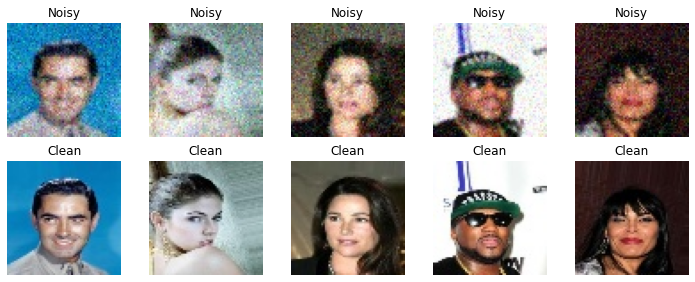

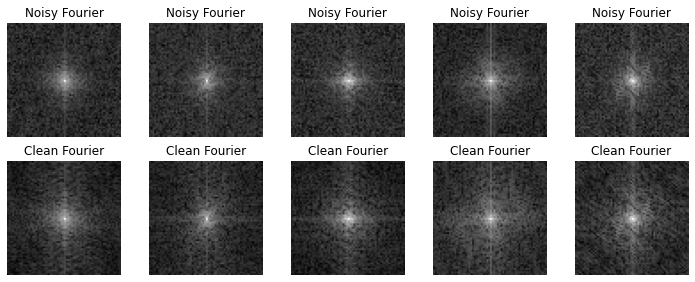

In [5]:
x_train_clean_fourier = [fourier_transform_image(img) for img in x_train_clean]
x_train_noisy_fourier = [fourier_transform_image(img) for img in x_train_noisy]
x_test_clean_fourier = [fourier_transform_image(img) for img in x_test_clean]
x_test_noisy_fourier = [fourier_transform_image(img) for img in x_test_noisy]

show_samples(x_train_clean, x_train_noisy)
show_samples_fourier(x_train_clean_fourier, x_train_noisy_fourier, "Clean Fourier", "Noisy Fourier")

### Split Comlex Channels for Training

In [6]:
def split_complex_channels(data):
    split_data = []
    for img_fft in data:  # img_fft: list of 3 channels (f_r, f_g, f_b)
        real_parts = [np.real(ch) for ch in img_fft]
        imag_parts = [np.imag(ch) for ch in img_fft]
        stacked = np.stack(real_parts + imag_parts, axis=-1)  # shape: (H, W, 6)
        split_data.append(stacked)
    return np.array(split_data, dtype=np.float32)  # shape: (N, H, W, 6)

def combine_complex_channels(data):
    assert data.shape[-1] == 6, "Input must have 6 channels (3 real + 3 imag)"
    real = data[..., :3]
    imag = data[..., 3:]
    combined = real + 1j * imag  # shape: (N, H, W, 3), complex
    return [ [combined[i, ..., ch] for ch in range(3)] for i in range(data.shape[0])]

def normalize_globally(data):
    mean = np.mean(data, axis=(0, 1, 2), keepdims=True)  # (1, 1, 1, 6)
    std = np.std(data, axis=(0, 1, 2), keepdims=True)
    return (data - mean) / (std + 1e-8), mean, std

def denormalize_globally(data, mean, std):
    return data * (std + 1e-8) + mean

x_train_clean_fourier_split = split_complex_channels(x_train_clean_fourier)
x_train_noisy_fourier_split = split_complex_channels(x_train_noisy_fourier)
x_test_clean_fourier_split = split_complex_channels(x_test_clean_fourier)
x_test_noisy_fourier_split = split_complex_channels(x_test_noisy_fourier)

### Normalize the Data

In [7]:
# Step 1: Concatenate all data to compute a shared global mean/std
all_split = np.concatenate([
    x_train_clean_fourier_split,
    x_train_noisy_fourier_split,
    x_test_clean_fourier_split,
    x_test_noisy_fourier_split
], axis=0)

# Step 2: Compute global mean and std
all_normalized, global_mean, global_std = normalize_globally(all_split)

# Step 3: Split normalized data back into the original sets
n_train_clean = len(x_train_clean_fourier_split)
n_train_noisy = len(x_train_noisy_fourier_split)
n_test_clean = len(x_test_clean_fourier_split)
n_test_noisy = len(x_test_noisy_fourier_split)

x_train_clean_fourier_norm = all_normalized[:n_train_clean]
x_train_noisy_fourier_norm = all_normalized[n_train_clean:n_train_clean + n_train_noisy]
x_test_clean_fourier_norm = all_normalized[n_train_clean + n_train_noisy:n_train_clean + n_train_noisy + n_test_clean]
x_test_noisy_fourier_norm = all_normalized[-n_test_noisy:]

## Exploratory Data Analysis

### Dataset Size

In [8]:
print("Train Clean:", x_train_clean_fourier_split.shape, x_train_clean_fourier_split.dtype)
print("Train Noisy:", x_train_noisy_fourier_split.shape)
print("Test Clean:", x_test_clean_fourier_split.shape)
print("Test Noisy:", x_test_noisy_fourier_split.shape)

Train Clean: (22500, 64, 64, 6) float32
Train Noisy: (22500, 64, 64, 6)
Test Clean: (2500, 64, 64, 6)
Test Noisy: (2500, 64, 64, 6)


### Channel Wise Stats

In [9]:
# def describe_channels(data, label=""):
#     mean = np.mean(data, axis=(0, 1, 2))
#     std = np.std(data, axis=(0, 1, 2))
#     print(f"{label} - Mean per channel: {mean}")
#     print(f"{label} - Std  per channel: {std}")

# describe_channels(x_train_clean_fourier_split, "Train Clean")
# describe_channels(x_train_noisy_fourier_split, "Train Noisy")

### Distribution and Value Ranges

In [10]:
# def plot_histograms(data, title_prefix):
#     fig, axs = plt.subplots(2, 3, figsize=(15, 6))
#     for i in range(6):
#         ax = axs[i // 3, i % 3]
#         ax.hist(data[..., i].ravel(), bins=100, color='steelblue', alpha=0.7)
#         ax.set_title(f"{title_prefix} - Channel {i}")
#         ax.set_xlim([-1, 1])  # Adjust depending on normalization
#     plt.tight_layout()
#     plt.show()

# plot_histograms(x_train_clean_fourier_split, "Clean")
# plot_histograms(x_train_noisy_fourier_split, "Noisy")

### Visualize Spectral Features

In [11]:
# def show_spectral_image(image, title=""):
#     # Expecting shape (H, W, 6)
#     fig, axs = plt.subplots(2, 3, figsize=(12, 6))
#     for i in range(6):
#         ax = axs[i // 3, i % 3]
#         ax.imshow(np.log1p(np.abs(image[..., i])), cmap='magma')
#         ax.set_title(f"{title} - Channel {i}")
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# show_spectral_image(x_train_clean_fourier_split[0], title="Clean")
# show_spectral_image(x_train_noisy_fourier_split[0], title="Noisy")

### Difference Analysis

In [12]:
# diff = x_train_noisy_fourier_split[0] - x_train_clean_fourier_split[0]
# show_spectral_image(diff, title="Noisy - Clean Difference")

## Model Creation

In [13]:
epochs = 1000
batch_size = 16
loss_function = "mse"
model_name = f"UDnCNN_fourier_{loss_function}_e{epochs}_b{batch_size}_v1"
tf.keras.backend.clear_session()

In [14]:
input_img = Input(shape=(x_train_clean_fourier_split.shape[1], x_train_clean_fourier_split.shape[2], x_train_clean_fourier_split.shape[3]))

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(x_train_clean_fourier_split.shape[3], (3, 3), padding='same')(u2)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, output])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss=loss_function)
# model.summary()

I0000 00:00:1743963892.867467   65595 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 94380 MB memory:  -> device: 0, name: NVIDIA GH200 480GB, pci bus id: 0000:dd:00.0, compute capability: 9.0


## Train the model

### Callback to Track Time

In [15]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()  # returns float in seconds

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time

time_callback = TimeHistory()

### Train

In [16]:
history = model.fit(
    x_train_noisy_fourier_split, x_train_clean_fourier_split,
    validation_data=(x_test_noisy_fourier_split, x_test_clean_fourier_split),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[time_callback]
)
print("Training time (seconds):", round(time_callback.total_time, 2))

Epoch 1/1000


I0000 00:00:1743963903.485669   65906 service.cc:148] XLA service 0xe80adc01ce60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743963903.485698   65906 service.cc:156]   StreamExecutor device (0): NVIDIA GH200 480GB, Compute Capability 9.0
2025-04-06 18:25:03.559746: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743963903.863437   65906 cuda_dnn.cc:529] Loaded cuDNN version 90701


  82/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.1053

I0000 00:00:1743963905.860223   65906 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 8.4526 - val_loss: 7.5667
Epoch 2/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.0872 - val_loss: 7.1295
Epoch 3/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.9525 - val_loss: 7.2715
Epoch 4/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.8665 - val_loss: 6.9997
Epoch 5/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.7575 - val_loss: 6.9122
Epoch 6/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.7443 - val_loss: 6.9395
Epoch 7/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.6855 - val_loss: 6.9234
Epoch 8/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.6911 - val_loss: 6.9542
Epoch 9/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.6268 - val_loss: 6.8702
Epoch 10/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.6312 - val_loss: 6.9452
Epoch 11/1000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 6.6256 - val_loss: 6.9404
Epoch 12/1000
1407/1

### Save

In [17]:
model_dir = f"./models/{model_name}"
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, "model.keras"))
print(f"\n✅ Model saved to: {model_dir}")


✅ Model saved to: ./models/UDnCNN_fourier_mse_e1000_b16_v1


## Evaluate the Model

### Predict

In [18]:
predictions_fourier_split = model.predict(x_test_noisy_fourier_split)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   


### Convert Back to Images

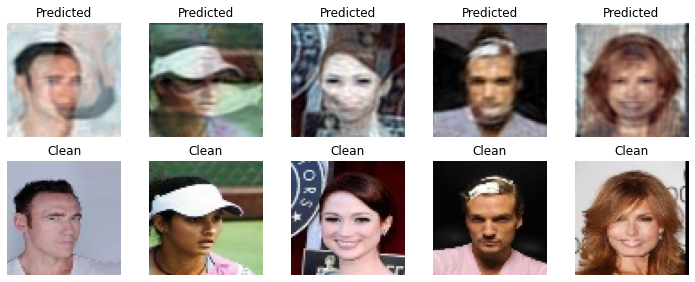

In [19]:
predictions_fourier_split_denorm = denormalize_globally(predictions_fourier_split, global_mean, global_std)
predictions_fourier = combine_complex_channels(predictions_fourier_split_denorm)
predictions = [inverse_fourier_transform(f) for f in predictions_fourier]
show_samples(x_test_clean, predictions, "Clean", "Predicted")

### Evaluate

In [20]:
mae = np.mean(np.abs(predictions - x_test_clean))
mse = np.mean((predictions - x_test_clean) ** 2)

psnr_total, ssim_total = 0, 0
for i in range(len(x_test_clean)):
    psnr_total += peak_signal_noise_ratio(x_test_clean[i], predictions[i], data_range=1.0)
    ssim_total += structural_similarity(x_test_clean[i], predictions[i], channel_axis=-1, data_range=1.0)

psnr_avg = psnr_total / len(x_test_clean)
ssim_avg = ssim_total / len(x_test_clean)

### Save Metadata

In [21]:
metadata = {
    "model_name": model_name,
    "created_at": datetime.now().isoformat(),
    "loss_function": loss_function,
    "epochs": int(epochs),
    "batch_size": int(batch_size),
    "training_time_seconds": round(float(time_callback.total_time), 2),
    "dataset_info": {
        "train_size": int(x_train_clean.shape[0]),
        "test_size": int(x_test_clean.shape[0]),
        "image_shape": list(map(int, x_train_clean.shape[1:]))
    },
    "evaluation_metrics": {
        "mae": round(float(mae), 6),
        "mse": round(float(mse), 6),
        "psnr_avg": round(float(psnr_avg), 3),
        "ssim_avg": round(float(ssim_avg), 3)
    }
}
with open(os.path.join(model_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Metadata saved to: {model_dir}")


✅ Metadata saved to: ./models/UDnCNN_fourier_mse_e1000_b16_v1


### Visualize the Results

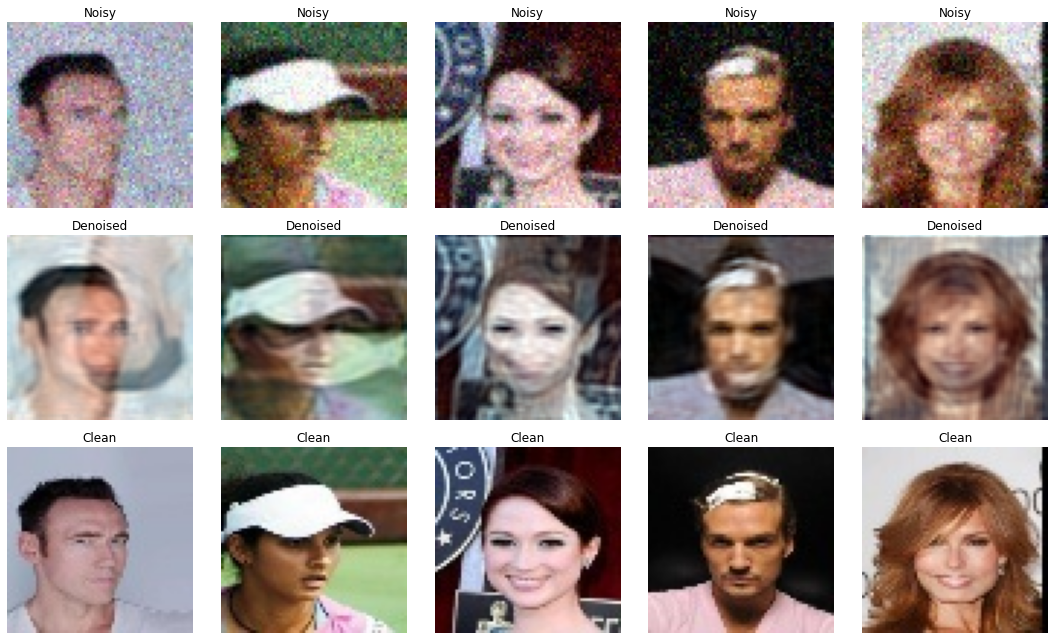

In [22]:
def show_predictions(noisy, clean, predicted, num_images=5):
    plt.figure(figsize=(num_images * 3, 9))
    for i in range(num_images):
        # Noisy
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Predicted
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(x_test_noisy, x_test_clean, predictions)

In [23]:
def visualize_and_save_denoising(noisy, predicted, clean, model_dir, num_images=5):
    """
    Visualize and save a comparison of noisy, denoised, and clean images.
    
    Args:
        noisy (numpy array): Noisy input images
        predicted (numpy array): Model predictions (denoised images)
        clean (numpy array): Ground truth clean images
        model_dir (str): Directory where the visualization image will be saved
        num_images (int): Number of image samples to visualize
    """
    plt.figure(figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Noisy input
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Denoised (model output)
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Ground truth
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(model_dir, "denoising_visualization.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

    print(f"📸 Visualization saved to: {save_path}")

visualize_and_save_denoising(
    noisy=x_test_noisy,
    predicted=predictions,
    clean=x_test_clean,
    model_dir=model_dir,
    num_images=5  # You can increase this number if desired
)

📸 Visualization saved to: ./models/UDnCNN_fourier_mse_e1000_b16_v1/denoising_visualization.png


### Visualize Final Results

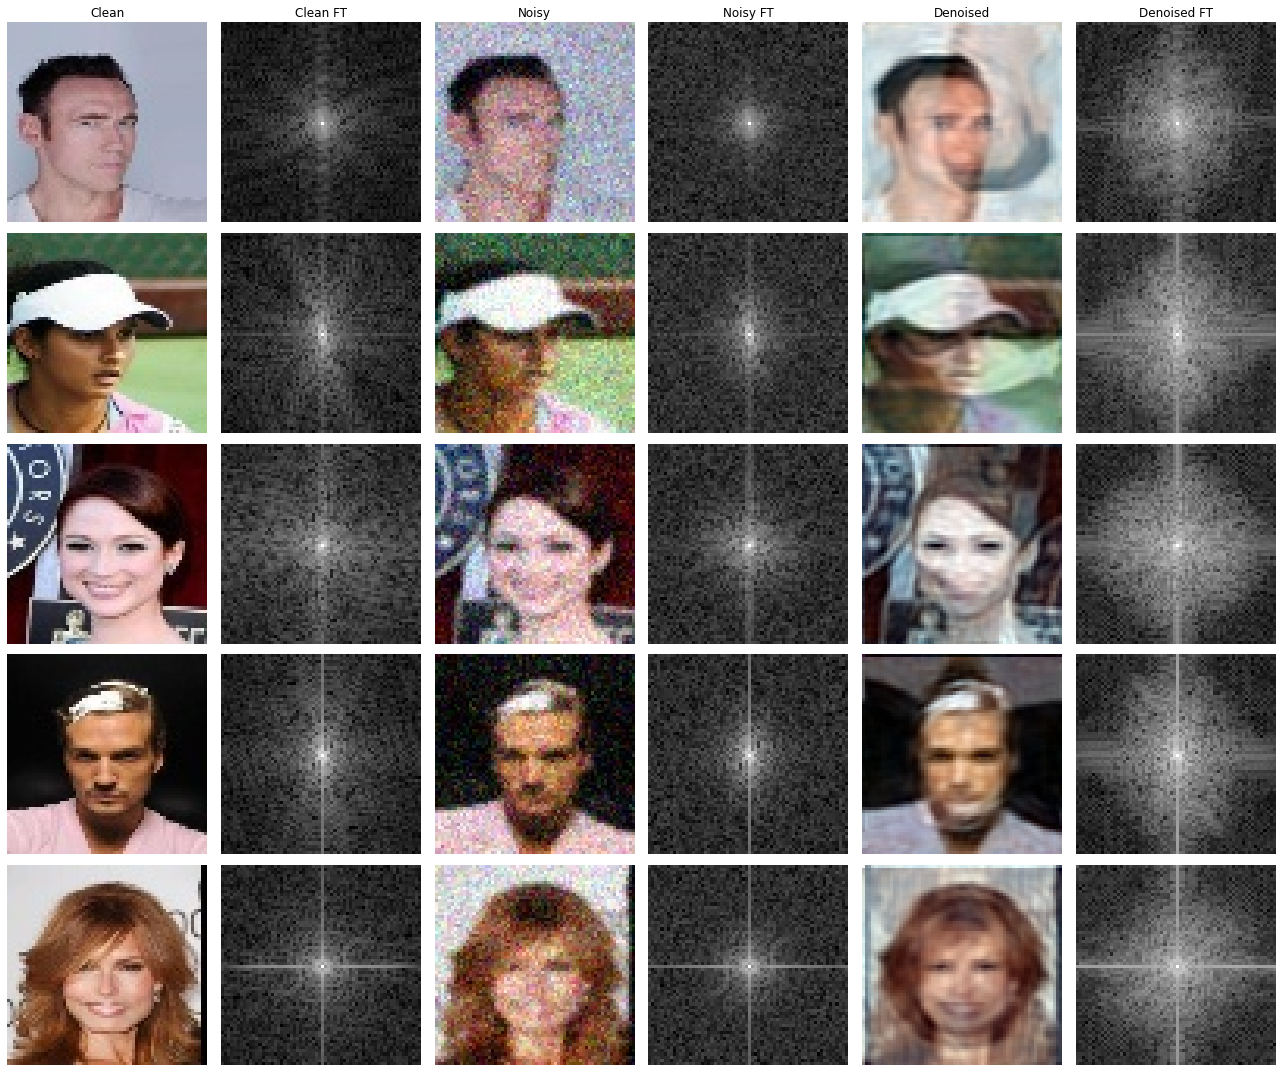

In [24]:
def plot_image_and_fourier_grid(clean_imgs, noisy_imgs, denoised_imgs, num_samples=5):
    def compute_fft_magnitude(img):
        if len(img.shape) == 3 and img.shape[-1] == 3:
            ffts = [np.fft.fftshift(np.fft.fft2(img[..., c])) for c in range(3)]
            mags = [20 * np.log(np.abs(f) + 1) for f in ffts]
            return np.mean(mags, axis=0)
        else:
            f = np.fft.fftshift(np.fft.fft2(img))
            return 20 * np.log(np.abs(f) + 1)

    def safe_imshow(img):
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            if img.dtype in [np.float32, np.float64]:
                img = np.clip(img, 0.0, 1.0)
            else:
                img = np.clip(img, 0, 255).astype(np.uint8)
            plt.imshow(img)

    titles = ["Clean", "Clean FT", "Noisy", "Noisy FT", "Denoised", "Denoised FT"]
    
    plt.figure(figsize=(18, 3 * num_samples))

    for i in range(num_samples):
        clean = clean_imgs[i]
        noisy = noisy_imgs[i]
        denoised = denoised_imgs[i]
        
        imgs = [
            clean,
            compute_fft_magnitude(clean),
            noisy,
            compute_fft_magnitude(noisy),
            denoised,
            compute_fft_magnitude(denoised)
        ]
        
        for j, img in enumerate(imgs):
            plt.subplot(num_samples, 6, i * 6 + j + 1)
            safe_imshow(img)
            plt.axis('off')
            if i == 0:
                plt.title(titles[j])

    plt.tight_layout()
    plt.show()

plot_image_and_fourier_grid(
    clean_imgs=x_test_clean,
    noisy_imgs=x_test_noisy,
    denoised_imgs=predictions,
    num_samples=5
)